Применим знания на практике: с помощью `pandahouse` попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне.

- ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

##### Step 2
Для начала, проверим правильность подключения к ClickHouse через `pandahouse`, отправив простой запрос: выведите количество строк в таблице `ldn_listings`.

In [1]:
# импортируем пандахаус
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080', 
                      'database':'default', 
                      'user':'student',  
                      'password':'dpo_python_2020' 
                     }

In [3]:
#  запрос количества строк
q = '''
SELECT COUNT()
FROM {db}.ldn_listings
'''

In [4]:
# считываем данные из ClickHouse, передавая запрос и параметры соединения
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


##### Step 3
Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

`price` – цена за ночь
`room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:
```
+-----------------+------------+
| room_type       | price      |
+-----------------+------------+
| Private room    |         65 | 
| Entire home/apt |        100 | 
+-----------------+------------+
```
Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн `[$,]` чтобы избавиться от `$` и запятых; toFloat32OrNull(столбец)

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [5]:
# запрос данных о цене в зависимости от типа жилья
q_price_vs_room_type = '''
SELECT
    id,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type
FROM
    ldn_listings
    
ORDER BY
    id

LIMIT 1000
'''

In [6]:
df_price_vs_room_type = ph.read_clickhouse(query=q_price_vs_room_type, connection=connection_default)
df_price_vs_room_type.head()

,id,price,room_type
0,13913,65.0,Private room
1,15400,100.0,Entire home/apt
2,17402,300.0,Entire home/apt
3,17506,150.0,Private room
4,25023,65.0,Entire home/apt


In [7]:
df_price_vs_room_type.dtypes

id            uint32
price        float32
room_type     object
dtype: object

In [8]:
(
    df_price_vs_room_type
        .groupby('room_type')
        .price
        .quantile(q=0.75)
)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

##### Step 4
К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (`review_scores_rating`). В запросе необходимо будет отфильтровать пустые значения `review_scores_rating` и сконвертировать эту колонку в тип `float32`.

Hint: `toFloat32OrNull(столбец)`

Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Исходная таблица должна выглядеть так:
```
+-----------------+------------+--------------------+
| room_type       | price      |review_scores_rating|
+-----------------+------------+--------------------+
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |
+-----------------+------------+--------------------+
```
1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [9]:
q_price_room_type_rating = '''
SELECT
    id,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM
    ldn_listings
WHERE
    review_scores_rating IS NOT NULL
ORDER BY
    id

LIMIT 1000
'''

In [10]:
price_room_type_rating = ph.read_clickhouse(query=q_price_room_type_rating, connection=connection_default)

In [11]:
price_room_type_rating.head()

,id,price,room_type,review_scores_rating
0,13913,65.0,Private room,97.0
1,15400,100.0,Entire home/apt,96.0
2,17402,300.0,Entire home/apt,94.0
3,25023,65.0,Entire home/apt,93.0
4,25123,29.0,Private room,96.0


In [12]:
price_room_type_rating.dtypes

id                       uint32
price                   float32
room_type                object
review_scores_rating    float32
dtype: object

In [13]:
# среднее для цены и рейтинга по типу жилья
scores_rating_mean = (
    price_room_type_rating
        .groupby('room_type', as_index=False)
        .agg({'price': 'mean', 'review_scores_rating': 'mean'})
)
scores_rating_mean.head()

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


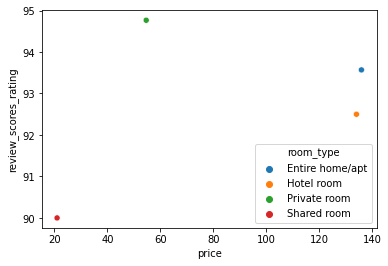

In [14]:
# график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья 
sns.scatterplot(x='price', y='review_scores_rating', hue='room_type', data=scores_rating_mean)

##### Step 5
Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

`host_id` – идентификатор хозяина (уникальный)  
`host_verifications` – какими способами хост подтвердил свой профиль  

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат `str([1, 2, 3]))`. Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
`"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']`

2. Используйте методы `explode` и `value_counts`, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [15]:
# запрос для кликхауса
q_impressions = '''
SELECT
    DISTINCT host_id,
    host_verifications
FROM
    ldn_listings
WHERE 
    experiences_offered != 'none'
'''

In [16]:
# считываем данные из кликхауса
impressions = ph.read_clickhouse(query=q_impressions, connection=connection_default)

In [17]:
impressions.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [18]:
# считаем сколько раз встречается способ авторизации google (способ №1)
(
    impressions
        .loc[impressions.host_verifications.str.contains('google')] # отбираем строки где содержится google
        .host_verifications                                         # выбираем столбец для полсчёта значений
        .count()                                                    # считаем
)

34

In [19]:
# переводим строковые данные колонки host_verifications в списоки
impressions['host_verifications'] =  \
impressions.host_verifications \
            .str. replace(' ', '') \
            .str.replace("'",'') \
            .str.strip('[]') \
            .str.split(',')

In [20]:
# считаем сколько раз встречается каждый способ авторизации (способ №2)
impressions.host_verifications.explode('host_verifications').value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

##### Step 6
Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите `experiences_count`.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – `family`.
```
+------------------------+---------------------+-------------------+
| neighbourhood_cleansed | experiences_offered | experiences_count |
+------------------------+---------------------+-------------------+
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |
+------------------------+---------------------+-------------------+
```
Отсортируйте данные по убыванию `experiences_count` и выгрузите первые 100 строк. Затем преобразуйте данные с помощью `pivot`, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью `sns.heatmap()` c палитрой `cmap=sns.cubehelix_palette(as_cmap=True)`. 

Какой график получился?

In [21]:
# запрос для кликхауса
q_experiences_count = '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(host_id) AS experiences_count
FROM
    {db}.ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
'''

In [22]:
# считываем данные из кликхауса
experiences_count = ph.read_clickhouse(query=q_experiences_count, connection=connection_default)

In [23]:
experiences_count.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [24]:
experiences_count_pivot = (
    experiences_count
        .pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
)

In [25]:
experiences_count_pivot.shape

(31, 4)

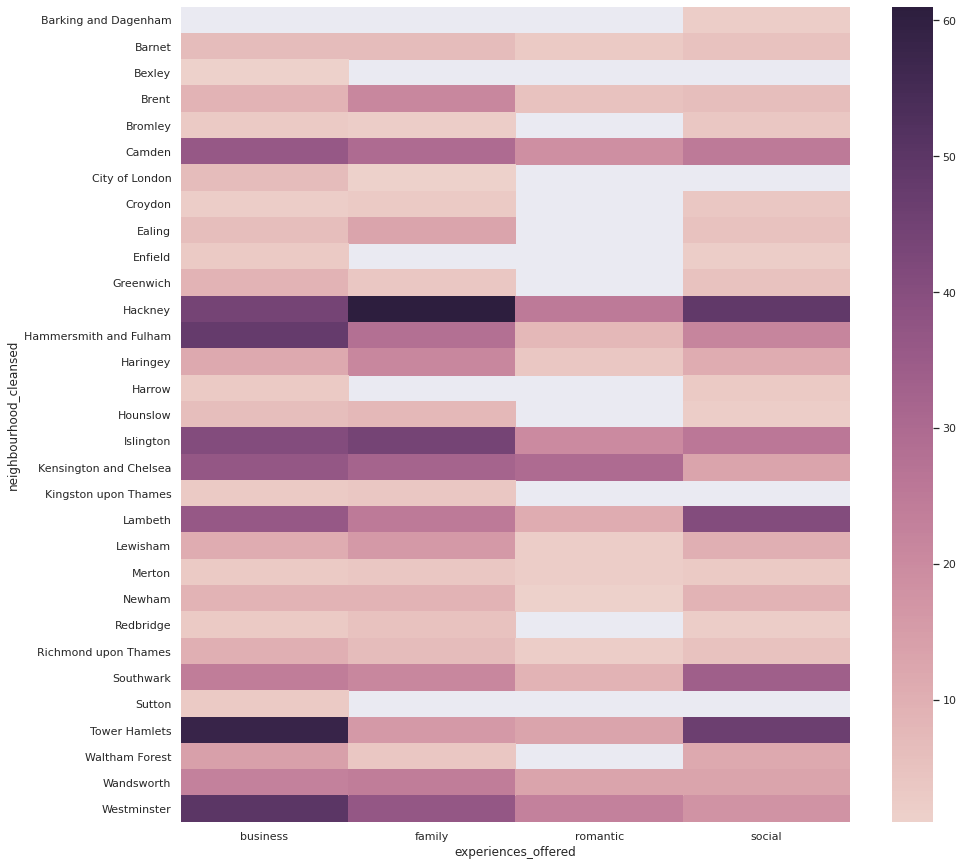

In [26]:
# рисуем heatmap
sns.set(rc = {'figure.figsize':(15,15)})         # устанавливаем размер карты
cmap=sns.cubehelix_palette(as_cmap=True)         # устанавливаем палитру
sns.heatmap(experiences_count_pivot, cmap=cmap)  # рисуем тепловую карту с указанием палитры

##### Step 7
Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

`room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
`price` – цена за ночь 
`experiences_offered` – вид доступного впечатления (оставить не 'none')  

Пример части результирующей таблицы:
```
+-----------------+------------+
| room_type       | price_corr |
+-----------------+------------+
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |
+-----------------+------------+
```
Hint: `replaceRegexpAll(столбец, что_заменить, на_что_заменить)` – паттерн `[$,]` чтобы избавиться от `$` и запятых; `toFloat32OrNull(столбец)`

Далее постройте два графика, используя `distplot` из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [27]:
# запрос для кликхауса
q_experiences_offered_price = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
FROM
    ldn_listings
WHERE 
    experiences_offered != 'none'
'''

In [28]:
experiences_offered_price = ph.read_clickhouse(query=q_experiences_offered_price, connection=connection_default)

In [29]:
experiences_offered_price.head()

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [30]:
experiences_offered_price['price_log'] = experiences_offered_price.price_corr.apply(np.log)

In [31]:
experiences_offered_price

,room_type,price_corr,price_log
0,Private room,65.0,4.174387
1,Entire home/apt,100.0,4.605170
2,Private room,150.0,5.010635
3,Private room,45.0,3.806663
4,Private room,25.0,3.218876
...,...,...,...
1543,Entire home/apt,100.0,4.605170
1544,Entire home/apt,125.0,4.828314
1545,Entire home/apt,185.0,5.220356
1546,Entire home/apt,110.0,4.700480


In [32]:
experiences_offered_price.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


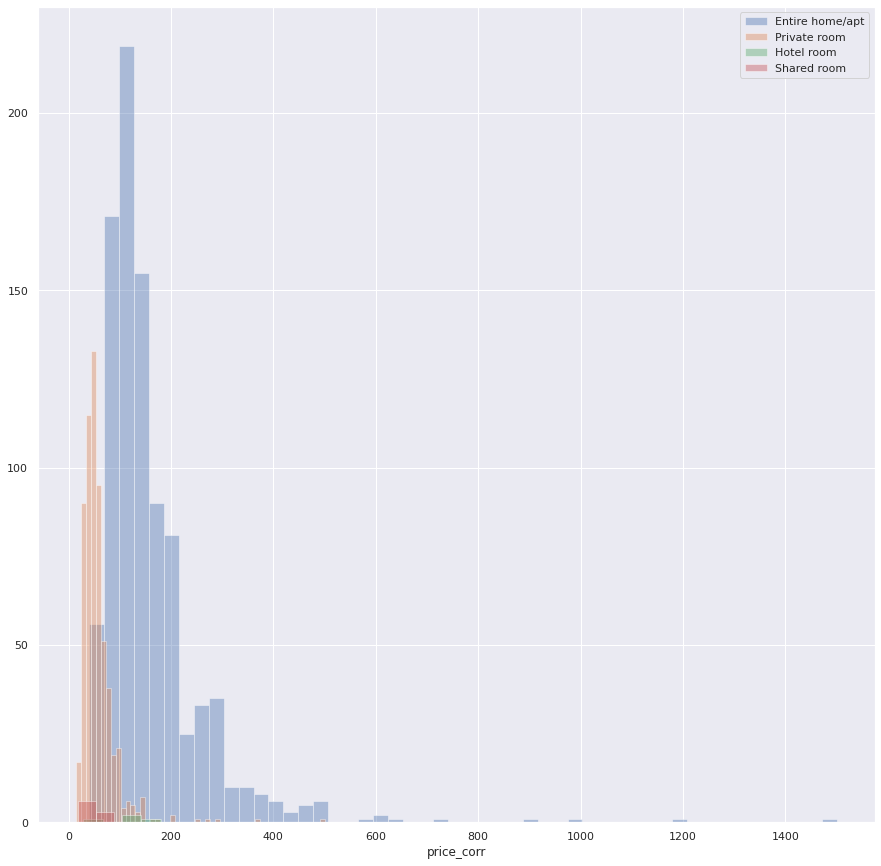

In [33]:
# рисуем графики для price_corr (вариант 1)
sns.distplot(experiences_offered_price \
             .query('room_type == "Entire home/apt"') \
             .price_corr, kde=False, label="Entire home/apt")
sns.distplot(experiences_offered_price \
             .query('room_type == "Private room"') \
             .price_corr, kde=False, label="Private room")
sns.distplot(experiences_offered_price \
             .query('room_type == "Hotel room"') \
             .price_corr, kde=False, label="Hotel room")
sns.distplot(experiences_offered_price \
             .query('room_type == "Shared room"') \
             .price_corr, kde=False, label="Shared room")

plt.legend() # включаем отображение легенды

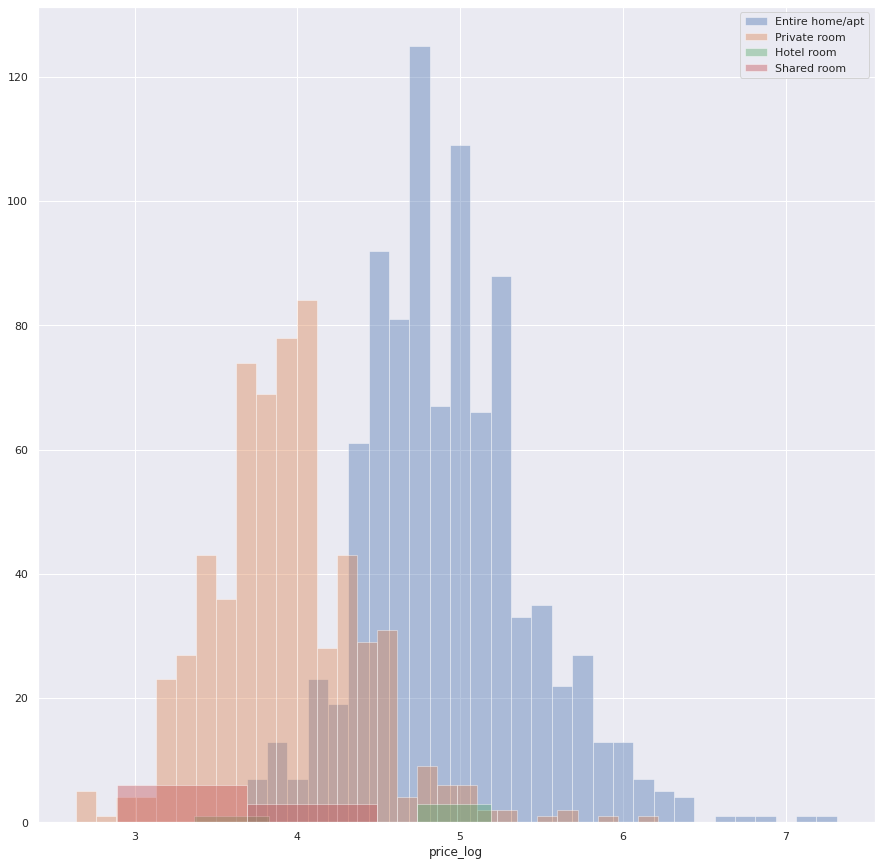

In [34]:
# рисуем графики для price_log (вариант 1)
sns.distplot(experiences_offered_price \
             .query('room_type == "Entire home/apt"') \
             .price_log, kde=False, label="Entire home/apt")
sns.distplot(experiences_offered_price \
             .query('room_type == "Private room"') \
             .price_log, kde=False, label="Private room")
sns.distplot(experiences_offered_price \
             .query('room_type == "Hotel room"') \
             .price_log, kde=False, label="Hotel room")
sns.distplot(experiences_offered_price \
             .query('room_type == "Shared room"') \
             .price_log, kde=False, label="Shared room")

plt.legend() # включаем отображение легенды

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


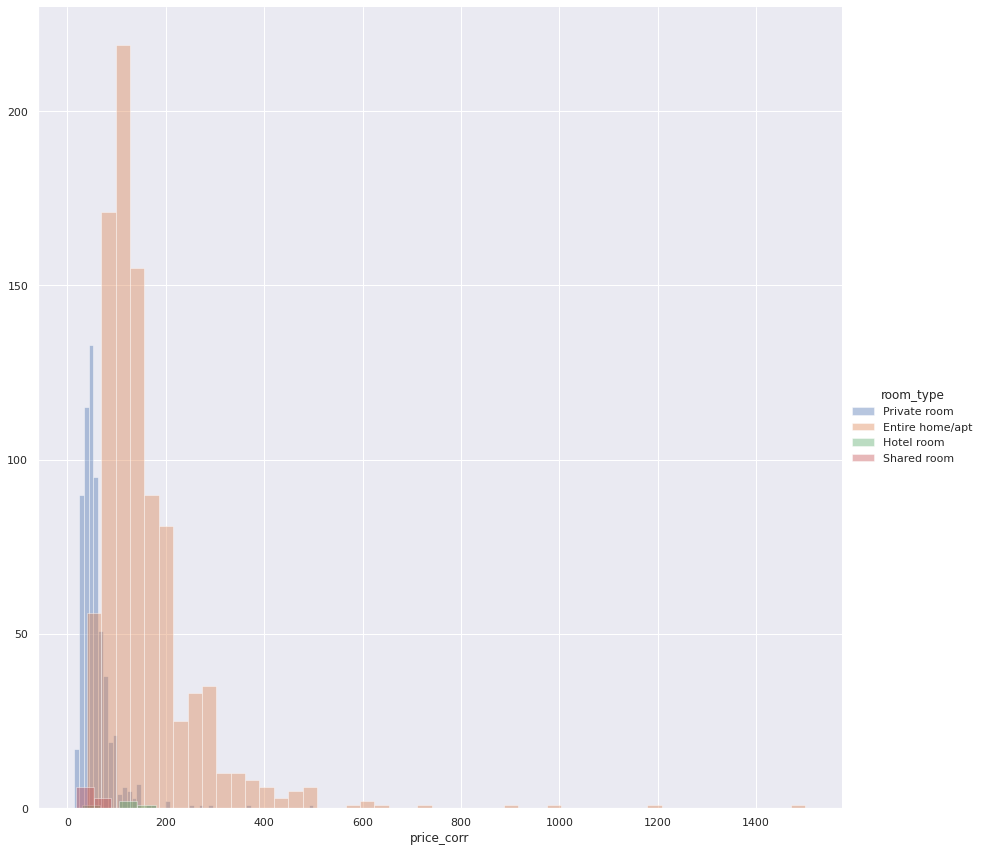

In [51]:
# рисуем графики для price_corr (вариант 2)
g = sns.FacetGrid(experiences_offered_price, hue='room_type', height=12, aspect=1) # указываем df, столбец для группировки, размер графика и пропорции
g.map(sns.distplot, 'price_corr', kde=False)                                       # указываем функцию графика, столбец и отключаем kde
g.add_legend()                                                                     # добавляем легенду

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


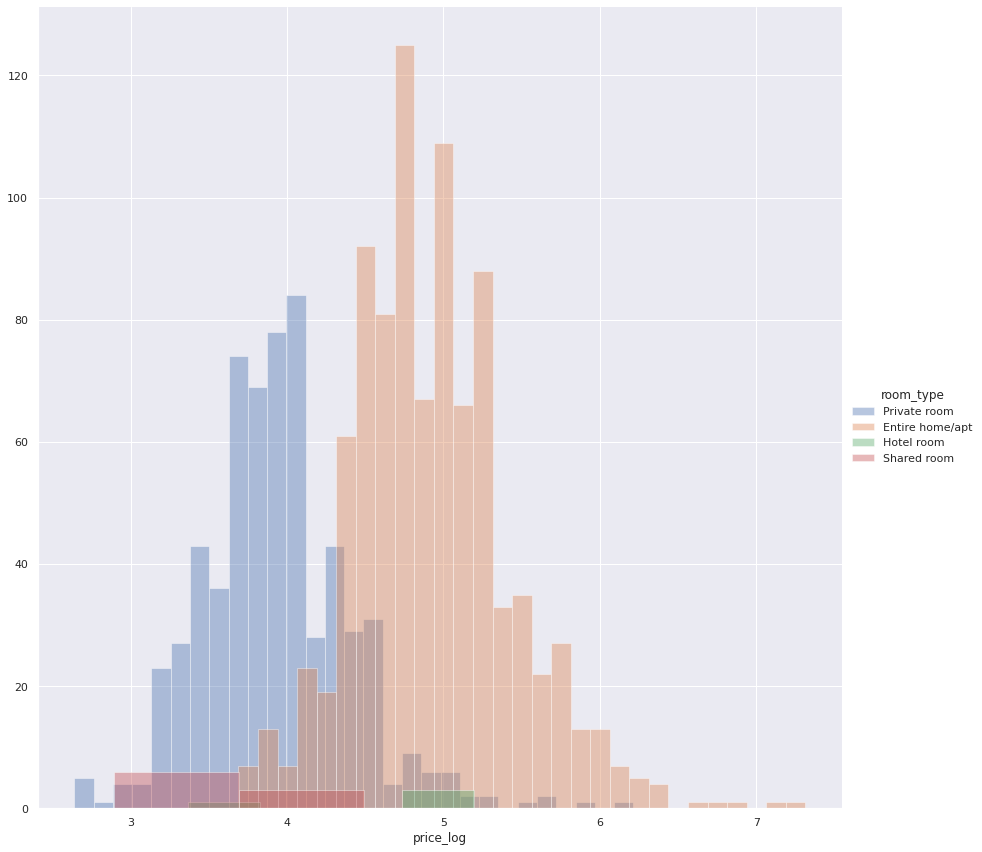

In [52]:
# рисуем графики для price_log (вариант 2)
g = sns.FacetGrid(experiences_offered_price, hue='room_type', height=12, aspect=1)
g.map(sns.distplot, 'price_log', kde=False)
g.add_legend();

##### Step 8
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

`room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)  
`price` – цена за ночь  
`first_review` – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.

Hint: `replaceRegexpAll(столбец, что_заменить, на_что_заменить)` – паттерн `[$,]` чтобы избавиться от `$` и запятых; `toFloat32OrNull(столбец)`

Пример результирующей таблицы:
```
+-----------------+------------+------------+
| room_type       | price_corr |first_review|
+-----------------+------------+------------+
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |
+-----------------+------------+------------+
```
Используя библиотеку seaborn и функцию `lineplot`, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:
```
+-----------------+------------+------------+
| room_type       | avg_price  | year       |
+-----------------+------------+------------+
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |
+-----------------+------------+------------+
```
Hints: `line plot`; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

In [35]:
q_first_review = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM
    ldn_listings
WHERE
    first_review > '2010-01-01'
LIMIT 1000
'''

In [36]:
first_review_df = ph.read_clickhouse(query=q_first_review, connection=connection_default)

In [37]:
first_review_df = first_review_df.sort_values('first_review')
first_review_df.head()

,room_type,price,first_review
3,Private room,29.0,2010-04-14
8,Private room,70.0,2010-07-21
19,Private room,60.0,2010-08-01
0,Private room,65.0,2010-08-18
7,Entire home/apt,80.0,2010-08-31


In [38]:
# осталвяем только год в колонке first_review
first_review_df['first_review'] = (
    first_review
        .first_review
        .apply(lambda x: x[:4])
)

NameError: name 'first_review' is not defined

In [ ]:
first_review_df = (
    first_review_df
        .groupby(['first_review', 'room_type'], as_index=False)
        .agg({'price': 'mean'})
)
first_review_df.head()

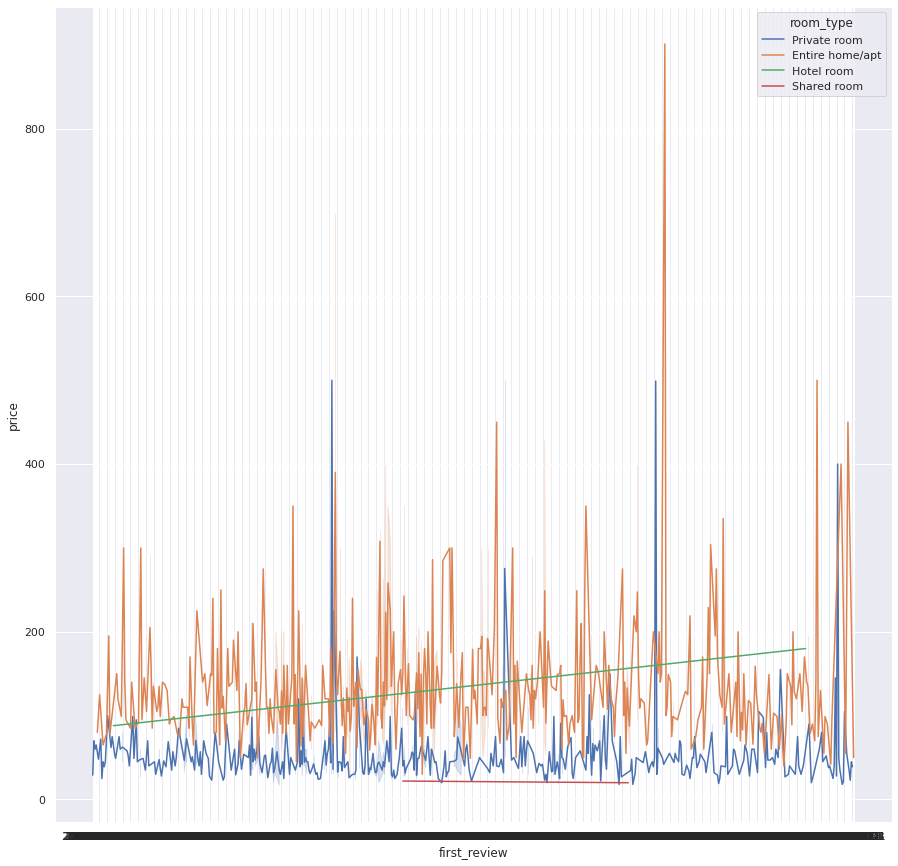

In [39]:
sns.lineplot(data=first_review_df, y='price', x='first_review', hue='room_type')